## Import Libraries

In [74]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from PIL import Image
import cv2

In [13]:
#!pip install tqdm
from tqdm import tqdm


from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as k

from tensorflow.keras.datasets import mnist

In [15]:
# set seed for reproducibility
seed_val = 9000
np.random.seed(seed_val)
random.seed(seed_val)

## Load MNIST dataset

In [16]:
(X_train, y_train), (X_test, y_test) =  mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [17]:
print('Size of the training_set: ', X_train.shape)
print('Size of the test_set: ', X_test.shape)
print('Shape of each image: ', X_train[0].shape)
print('Total number of classes: ', len(np.unique(y_train)))
print('Unique class labels: ', np.unique(y_train))

Size of the training_set:  (60000, 28, 28)
Size of the test_set:  (10000, 28, 28)
Shape of each image:  (28, 28)
Total number of classes:  10
Unique class labels:  [0 1 2 3 4 5 6 7 8 9]


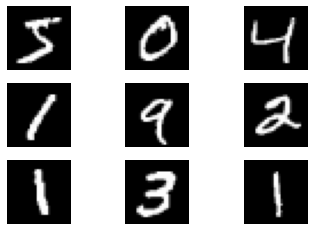

In [18]:
# Plot of 9 random images
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(X_train[i], cmap='gray') # gray scale

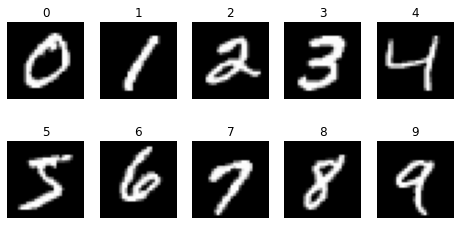

In [22]:
# plotting image from each class
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title(str(i)) # label 
    plt.axis('off') # turn off axis
    plt.imshow(X_train[np.where(y_train==i)][0], cmap='gr') # gray scale
plt.show()

In [23]:
print('Maximum pixel value in the training_set: ', np.max(X_train))
print('Minimum pixel value in the training_set: ', np.min(X_train))

Maximum pixel value in the training_set:  255
Minimum pixel value in the training_set:  0


In [24]:
# Converting integer values to float types 
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [25]:
# Scaling and centering
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5)/ 127.5
print('Maximum pixel value in the training_set after Centering and Scaling: ', np.max(X_train))
print('Minimum pixel value in the training_set after Centering and Scaling: ', np.min(X_train))

Maximum pixel value in the training_set after Centering and Scaling:  1.0
Minimum pixel value in the training_set after Centering and Scaling:  -1.0


In [26]:
# Rescale the pixel values (0 and 255)
def upscale(image):
    return (image*127.5 + 127.5).astype(np.uint8)

In [27]:
# Lets see if this works
z = upscale(X_train[0])
print('Maximum pixel value after upscaling scaled image: ',np.max(z))
print('Maximum pixel value after upscaling scaled image: ',np.min(z))

Maximum pixel value after upscaling scaled image:  255
Maximum pixel value after upscaling scaled image:  0


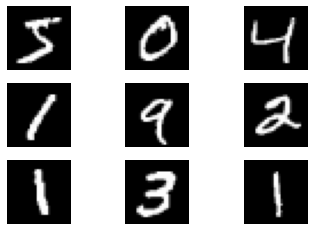

In [28]:
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(upscale(X_train[i]), cmap='gray') # gray scale

In [29]:
def noising(image):
    array = np.array(image)
    i = random.choice(range(8,12)) # x coordinate for the top left corner of the mask
    j = random.choice(range(8,12)) # y coordinate for the top left corner of the mask
    array[i:i+8, j:j+8]=-1.0 # setting the pixels in the masked region to -1
    return array

In [30]:
noised_train_data = np.array([*map(noising, X_train)])
noised_test_data = np.array([*map(noising, X_test)])
print('Noised train data Shape/Dimension : ', noised_train_data.shape)
print('Noised test data Shape/Dimension : ', noised_train_data.shape)

Noised train data Shape/Dimension :  (60000, 28, 28)
Noised test data Shape/Dimension :  (60000, 28, 28)


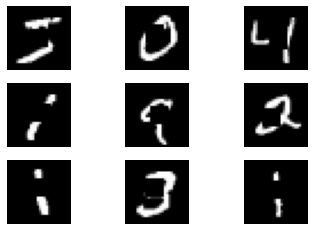

In [31]:
# Plot of 9 scaled noised images after upscaling
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(upscale(noised_train_data[i]), cmap='gray') # gray scale

In [32]:
# Reshaping the training data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print('Size/Shape of the original training set: ', X_train.shape)

Size/Shape of the original training set:  (60000, 28, 28, 1)


In [33]:
# Reshaping the noised training data
noised_train_data = noised_train_data.reshape(noised_train_data.shape[0],
noised_train_data.shape[1],
noised_train_data.shape[2], 1)
print('Size/Shape of the noised training set: ', noised_train_data.shape)

# Reshaping the testing data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Size/Shape of the original test set: ', X_test.shape)

# Reshaping the noised testing data
noised_test_data = noised_test_data.reshape(noised_test_data.shape[0],
noised_test_data.shape[1],
noised_test_data.shape[2], 1)
print('Size/Shape of the noised test set: ', noised_test_data.shape)

Size/Shape of the noised training set:  (60000, 28, 28, 1)
Size/Shape of the original test set:  (10000, 28, 28, 1)
Size/Shape of the noised test set:  (10000, 28, 28, 1)


In [34]:
# input image shape
input_shape = (28,28,1)

In [36]:
def train_mnist(input_shape, X_train, y_train):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=2, padding='same',
    input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam', metrics = ['accuracy'])
    model.fit(X_train, y_train, batch_size = 128, 
    epochs = 3, validation_split=0.2, verbose = 1 )
    return model

mnist_model = train_mnist(input_shape, X_train, y_train)

Epoch 1/3
375/375 [==============================] - 88s 235ms/step - loss: 0.2359 - accuracy: 0.9269 - val_loss: 0.0756 - val_accuracy: 0.9783
Epoch 2/3
375/375 [==============================] - 79s 210ms/step - loss: 0.0689 - accuracy: 0.9779 - val_loss: 0.0475 - val_accuracy: 0.9843
Epoch 3/3
375/375 [==============================] - 79s 211ms/step - loss: 0.0471 - accuracy: 0.9855 - val_loss: 0.0398 - val_accuracy: 0.9879


In [37]:
# prediction on the masked images
pred_labels = mnist_model.predict_classes(noised_test_data)
print('The model model accuracy on the masked images is:',np.mean(pred_labels==y_test)*100)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
The model model accuracy on the masked images is: 74.5


In [68]:
img = Image.open('converted3.png')
img = np.resize(img, (28,28,1))
im2arr = np.array(img)
im2arr = im2arr.reshape(1,28,28,1)
y_pred = mnist_model.predict_classes(im2arr)
print(y_pred)

[8]


### Detect digits in picture 




----------------Contoured Image--------------------


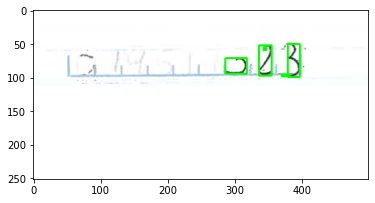

In [75]:
image = cv2.imread('Numero.png')
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
preprocessed_digits = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    
    # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
    cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
    
    # Cropping out the digit from the image corresponding to the current contours in the for loop
    digit = thresh[y:y+h, x:x+w]
    
    # Resizing that digit to (18, 18)
    resized_digit = cv2.resize(digit, (18,18))
    
    # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
    padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)
    
    # Adding the preprocessed digit to the list of preprocessed digits
    preprocessed_digits.append(padded_digit)
print("\n\n\n----------------Contoured Image--------------------")
plt.imshow(image, cmap="gray")
plt.show()
    
inp = np.array(preprocessed_digits)

### Apply prediction on every detected zone



---------------------------------------


=========PREDICTION============ 




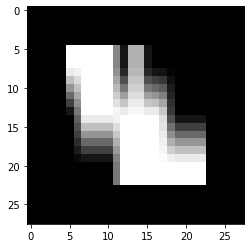



Final Output: 8

Prediction (Softmax) from the neural network:

 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




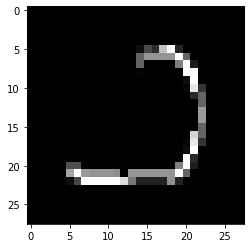



Final Output: 0

Prediction (Softmax) from the neural network:

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Hard-maxed form of the prediction: 

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




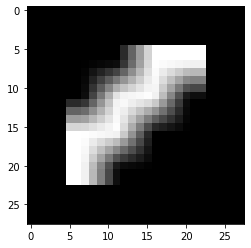



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




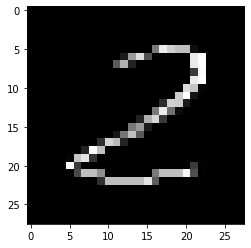



Final Output: 2

Prediction (Softmax) from the neural network:

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




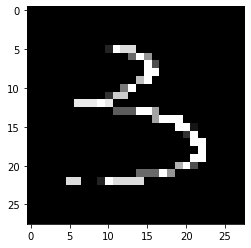



Final Output: 3

Prediction (Softmax) from the neural network:

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




In [77]:
for digit in preprocessed_digits:
    prediction = mnist_model.predict(digit.reshape(1, 28, 28, 1))  
    
    print ("\n\n---------------------------------------\n\n")
    print ("=========PREDICTION============ \n\n")
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()
    print("\n\nFinal Output: {}".format(np.argmax(prediction)))
    
    print ("\nPrediction (Softmax) from the neural network:\n\n {}".format(prediction))
    
    hard_maxed_prediction = np.zeros(prediction.shape)
    hard_maxed_prediction[0][np.argmax(prediction)] = 1
    print ("\n\nHard-maxed form of the prediction: \n\n {}".format(hard_maxed_prediction))
    print ("\n\n---------------------------------------\n\n")